# Subjects Memory Performance Measurment

In [3]:
from setup import *
config = load_config()

In [4]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Behavioral covariates


## Task performance measures

The dataset also includes aggregate behavior for each task run stored in task-specific `.csv` files. It is possible to load and work with these files using `numpy`:

In [5]:
wm_behavior = np.genfromtxt(os.path.join(config["HCP_DIR"], "hcp", "behavior", "wm.csv"),
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
print(wm_behavior[:5])
print(wm_behavior.dtype.names)

[(0, 0, '0BK_BODY', 1., 1., 1.,  705.5,  740.5, 696. )
 (0, 0, '0BK_FACE', 1., 1., 1.,  779.5,  765. , 915. )
 (0, 0, '0BK_PLACE', 1., 1., 1.,  926. ,  993.5, 811.5)
 (0, 0, '0BK_TOOL', 1., 1., 1.,  807.5,  807.5, 807.5)
 (0, 0, '2BK_BODY', 1., 1., 1., 1133. , 1205.5, 732.5)]
('Subject', 'Run', 'ConditionName', 'ACC', 'ACC_NONTARGET', 'ACC_TARGET', 'MEDIAN_RT', 'MEDIAN_RT_NONTARGET', 'MEDIAN_RT_TARGET')


But, while not formally taught as part of the course, [`pandas`](https://pandas.pydata.org/) offers more powerful tools for tabular data analysis.

### Measuring subjects memory performance:

In [6]:
hcp_columns = ['Subject', 'Run', 'ConditionName', 'ACC', 'ACC_NONTARGET', 'ACC_TARGET', 'MEDIAN_RT', 'MEDIAN_RT_NONTARGET', 'MEDIAN_RT_TARGET']
result_columns = ['Subject', '0BK_ACC', '0BK_MEDIAN_RT', '0BK_D_PRIME', '2BK_ACC', '2BK_MEDIAN_RT', '2BK_D_PRIME']
df = pd.DataFrame(wm_behavior, columns=hcp_columns)

In [9]:
from scipy.stats import norm

def calculate_d_prime(acc_target, acc_nontarget):
    false_alarm_rate = 1 - acc_nontarget
    
    # Avoid extreme values for hit rate and false alarm rate
    hit_rate = np.clip(acc_target, 0.01, 0.99)
    false_alarm_rate = np.clip(false_alarm_rate, 0.01, 0.99)
    
    # Calculate Z(H) and Z(FA)
    Z_H = norm.ppf(hit_rate)
    Z_FA = norm.ppf(false_alarm_rate)
    
    # Calculate d'
    d_prime = Z_H - Z_FA
    return d_prime

def calculate_single_subject_performance_metrics(df, subject_id):
    subject_data = df[df['Subject'] == subject_id]

    zero_back = subject_data[subject_data['ConditionName'].str.startswith('0BK')]
    two_back = subject_data[subject_data['ConditionName'].str.startswith('2BK')]

    zero_back_acc = zero_back['ACC'].mean() if not zero_back.empty else None
    zero_back_rt = zero_back['MEDIAN_RT'].mean() if not zero_back.empty else None
    zero_back_d_prime = calculate_d_prime(zero_back['ACC_TARGET'].mean(), zero_back['ACC_NONTARGET'].mean())

    two_back_acc = two_back['ACC'].mean() if not two_back.empty else None
    two_back_rt = two_back['MEDIAN_RT'].mean() if not two_back.empty else None
    two_back_d_prime = calculate_d_prime(two_back['ACC_TARGET'].mean(), two_back['ACC_NONTARGET'].mean())

    return pd.DataFrame([[subject_id, zero_back_acc, zero_back_rt, zero_back_d_prime,
                          two_back_acc, two_back_rt, two_back_d_prime]], columns=result_columns)

def calculate_memory_performance(df):
    subjects = df['Subject'].unique()
    performance_metrics = []

    for subject_id in subjects:
        subject_metrics = calculate_single_subject_performance_metrics(df, subject_id)
        performance_metrics.append(subject_metrics)

    performance_metrics_df = pd.concat(performance_metrics, ignore_index=True)
    return performance_metrics_df

In [11]:
# calculate_single_subject_performance_metrics(df, 15)
memory_performance_metrics = calculate_memory_performance(df)
print(memory_performance_metrics.head(20))

    Subject  0BK_ACC  0BK_MEDIAN_RT  0BK_D_PRIME   2BK_ACC  2BK_MEDIAN_RT  \
0         0   1.0000       852.2500     4.652696  0.921875      1054.4375   
1         1   1.0000       529.0625     4.652696  0.968750       865.5625   
2         2   0.9875       584.1250     3.860468  0.921875       940.5625   
3         3   0.9750       731.7500     3.687995  0.703125       798.0000   
4         4   0.6750       852.8125     0.579132  0.765625       864.0625   
5         5   1.0000       699.5000     4.652696  0.906250       996.0000   
6         6   0.9500       697.3750     3.013081  0.859375      1045.7500   
7         7   0.7875       799.8125     0.829234  0.671875       778.7500   
8         8   0.7125      1012.0000    -0.072834  0.875000      1052.1250   
9         9   0.6875       907.1875     1.119586  0.640625       977.0625   
10       10   0.7375      1018.3750     0.933732  0.828125      1040.3750   
11       11   0.9375       782.0625     2.749878  1.000000       904.7500   

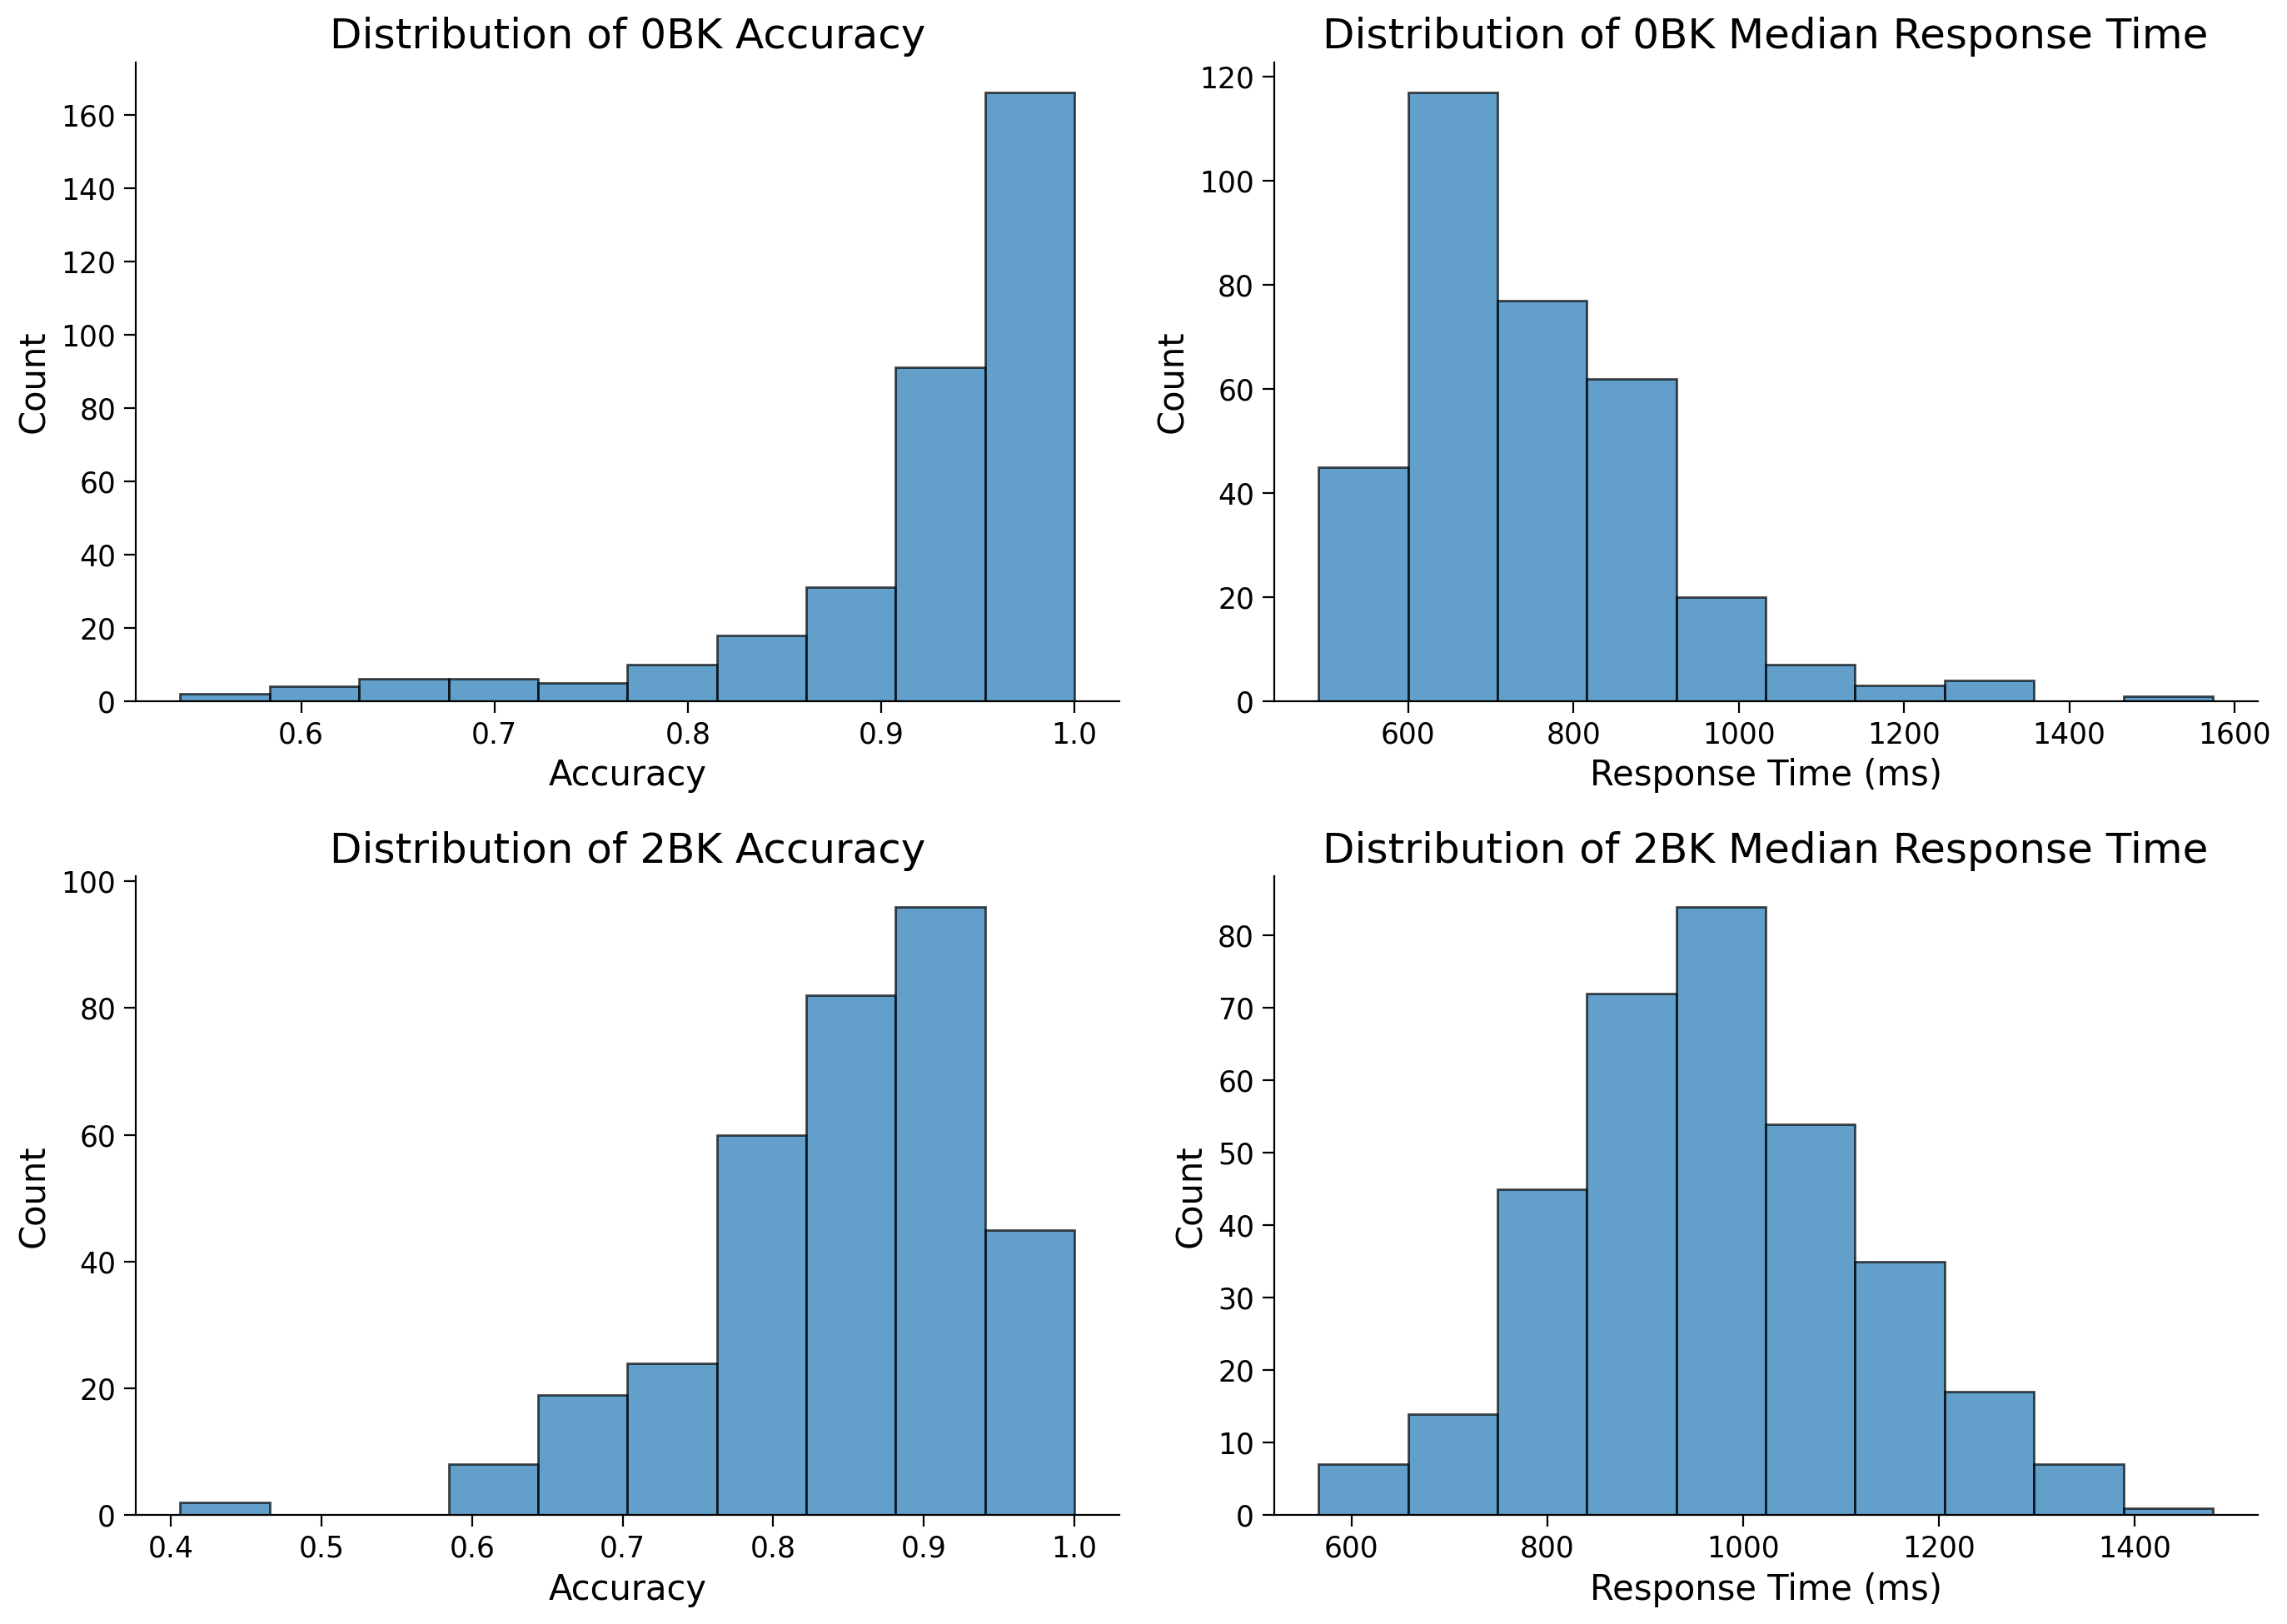

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Plot 0BK_ACC Histogram
axes[0, 0].hist(memory_performance_metrics['0BK_ACC'].dropna(), bins=10, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of 0BK Accuracy')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_ylabel('Count')

# Plot 0BK_MEDIAN_RT Histogram
axes[0, 1].hist(memory_performance_metrics['0BK_MEDIAN_RT'].dropna(), bins=10, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of 0BK Median Response Time')
axes[0, 1].set_xlabel('Response Time (ms)')
axes[0, 1].set_ylabel('Count')

# Plot 2BK_ACC Histogram
axes[1, 0].hist(memory_performance_metrics['2BK_ACC'].dropna(), bins=10, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of 2BK Accuracy')
axes[1, 0].set_xlabel('Accuracy')
axes[1, 0].set_ylabel('Count')

# Plot 2BK_MEDIAN_RT Histogram
axes[1, 1].hist(memory_performance_metrics['2BK_MEDIAN_RT'].dropna(), bins=10, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribution of 2BK Median Response Time')
axes[1, 1].set_xlabel('Response Time (ms)')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

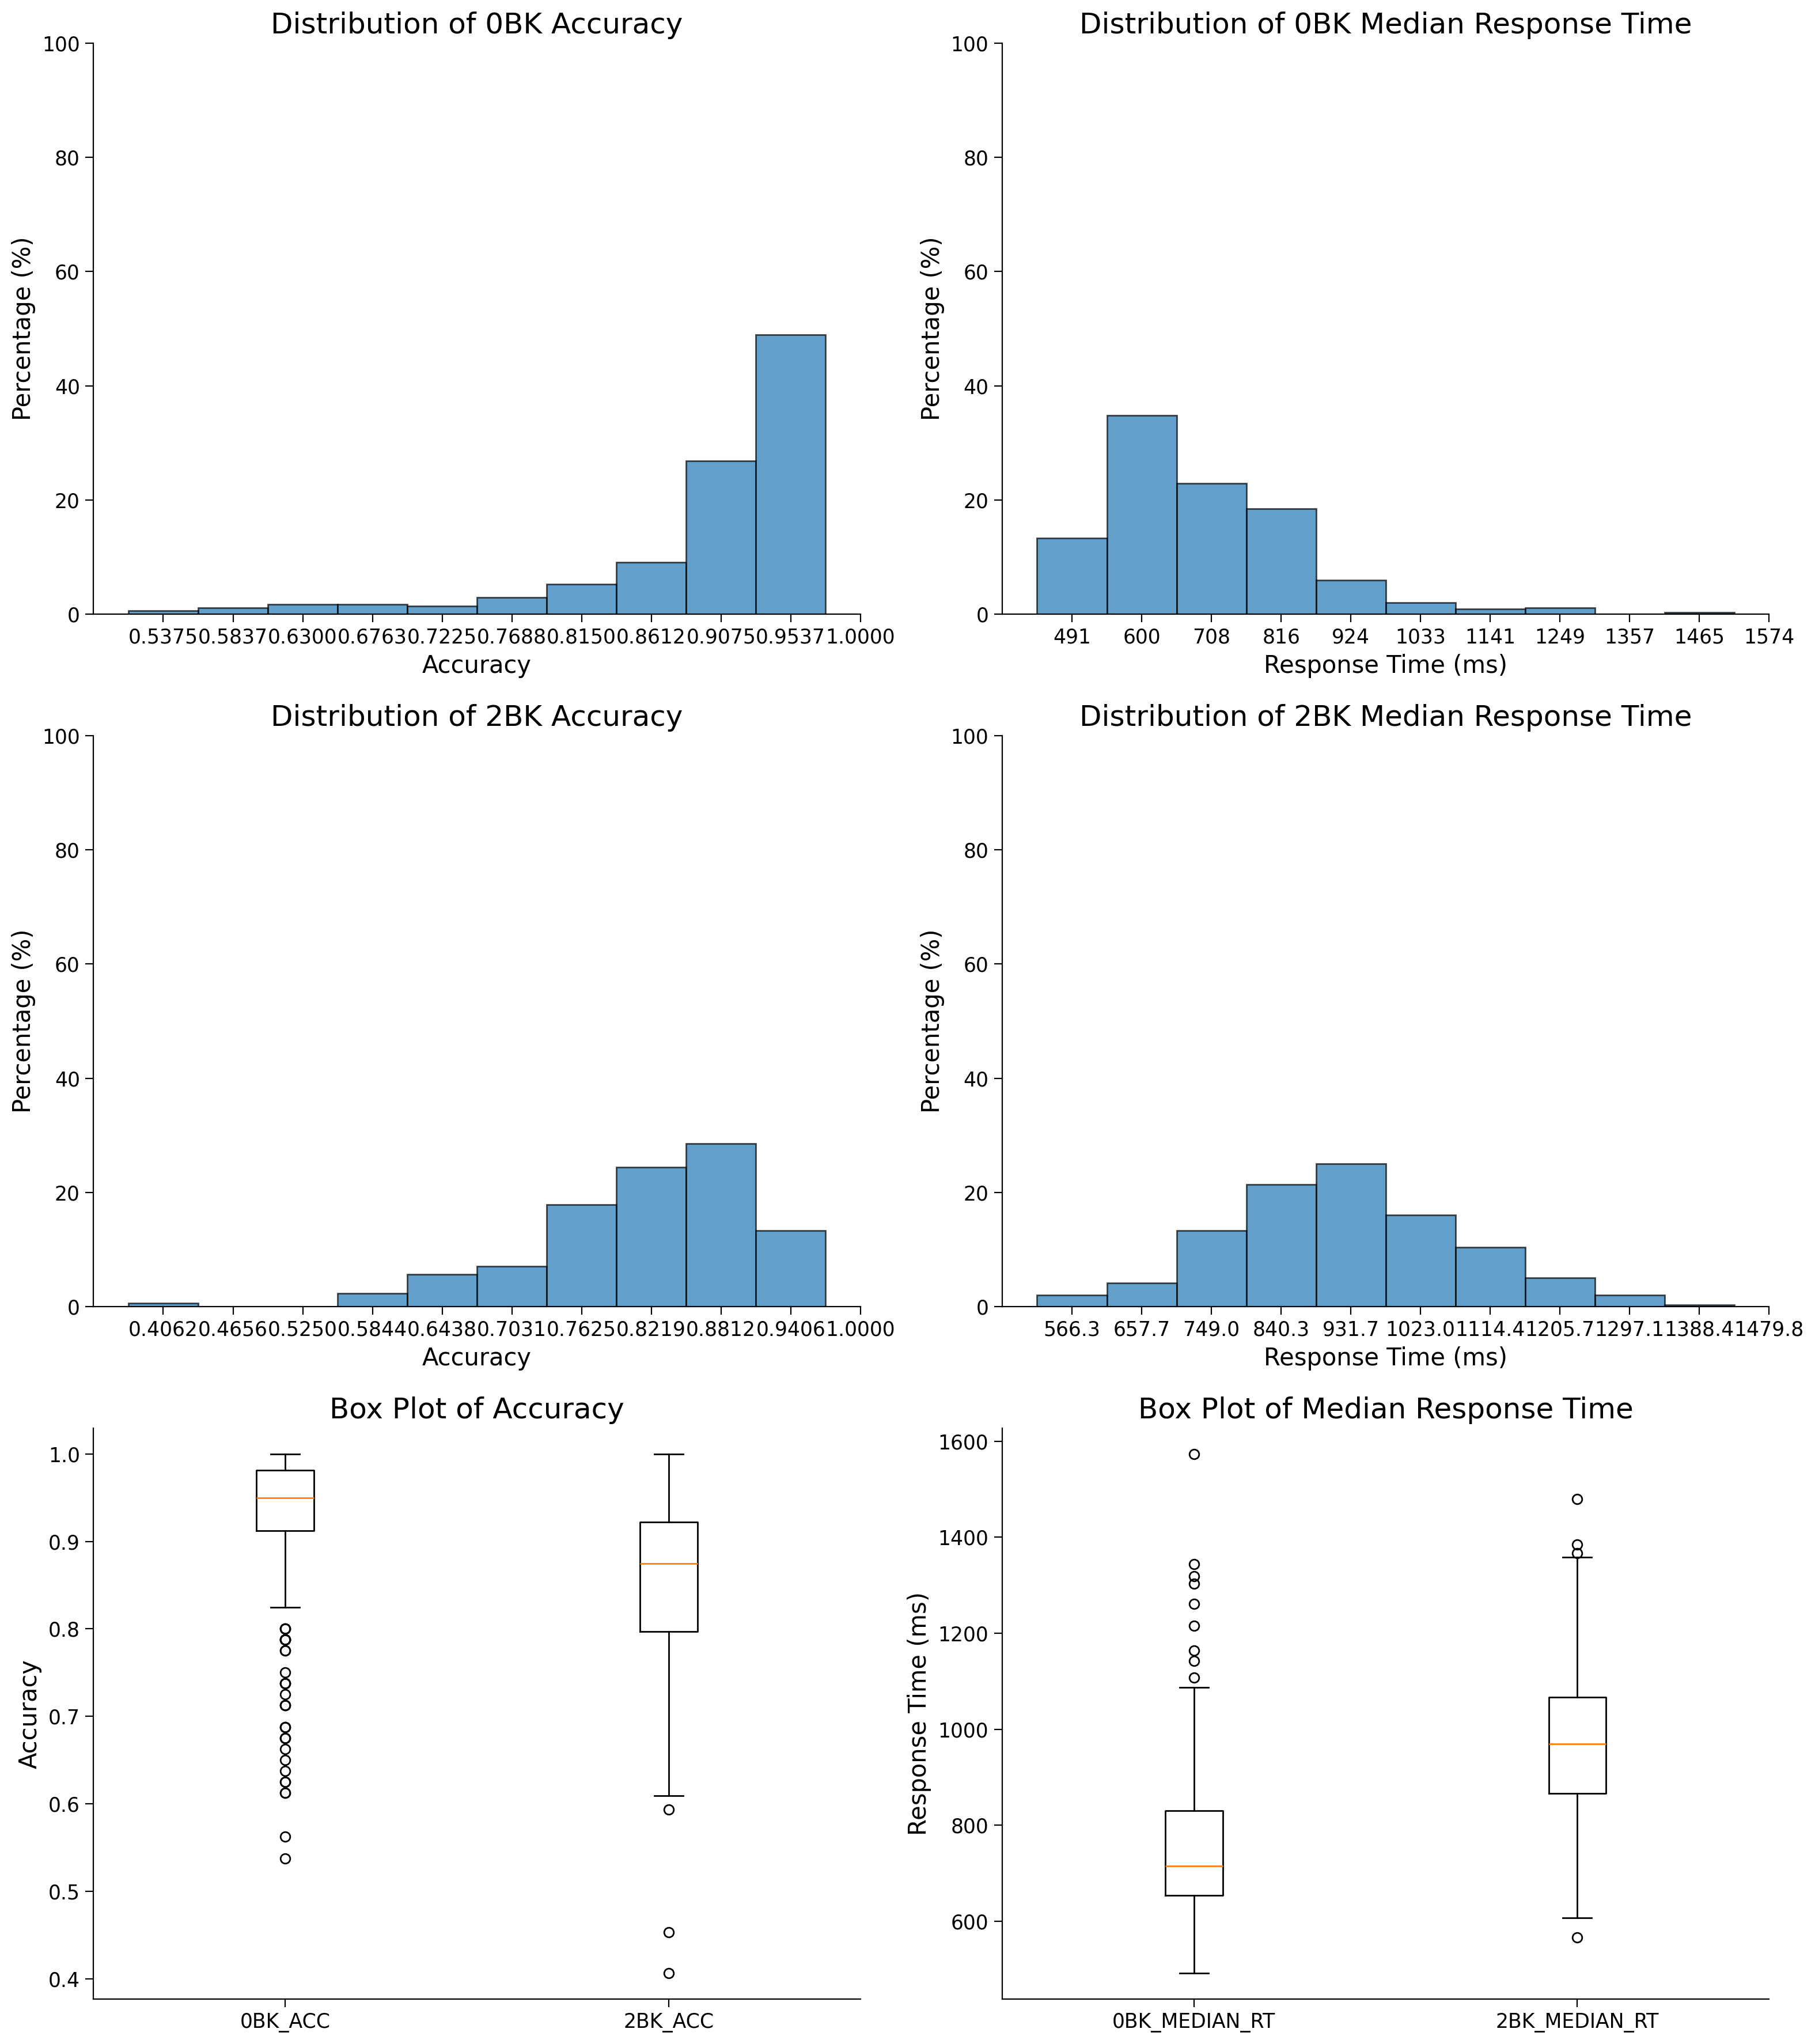

In [13]:
# Plotting the performance metrics

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))

# Function to calculate histogram percentage
def plot_percentage_histogram(data, ax, title, xlabel, ylabel):
    counts, bins, patches = ax.hist(data.dropna(), bins=10, edgecolor='black', alpha=0.7)
    percentages = (counts / counts.sum()) * 100  # Calculate percentages
    ax.clear()  # Clear the histogram to replot with percentages
    ax.bar(bins[:-1], percentages, width=np.diff(bins), edgecolor='black', alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(0, 100)  # Set y-limit to 100% for better readability
    ax.set_xticks(bins)  # Set x-ticks to match bin edges for clarity

# Plot 0BK_ACC Histogram as percentage with doubled bins
plot_percentage_histogram(memory_performance_metrics['0BK_ACC'], axes[0, 0], 'Distribution of 0BK Accuracy', 'Accuracy', 'Percentage (%)')

# Plot 0BK_MEDIAN_RT Histogram as percentage with doubled bins
plot_percentage_histogram(memory_performance_metrics['0BK_MEDIAN_RT'], axes[0, 1], 'Distribution of 0BK Median Response Time', 'Response Time (ms)', 'Percentage (%)')

# Plot 2BK_ACC Histogram as percentage with doubled bins
plot_percentage_histogram(memory_performance_metrics['2BK_ACC'], axes[1, 0], 'Distribution of 2BK Accuracy', 'Accuracy', 'Percentage (%)')

# Plot 2BK_MEDIAN_RT Histogram as percentage with doubled bins
plot_percentage_histogram(memory_performance_metrics['2BK_MEDIAN_RT'], axes[1, 1], 'Distribution of 2BK Median Response Time', 'Response Time (ms)', 'Percentage (%)')

# Plot Box Plots
axes[2, 0].boxplot([memory_performance_metrics['0BK_ACC'].dropna(), memory_performance_metrics['2BK_ACC'].dropna()], labels=['0BK_ACC', '2BK_ACC'])
axes[2, 0].set_title('Box Plot of Accuracy')
axes[2, 0].set_ylabel('Accuracy')

axes[2, 1].boxplot([memory_performance_metrics['0BK_MEDIAN_RT'].dropna(), memory_performance_metrics['2BK_MEDIAN_RT'].dropna()], labels=['0BK_MEDIAN_RT', '2BK_MEDIAN_RT'])
axes[2, 1].set_title('Box Plot of Median Response Time')
axes[2, 1].set_ylabel('Response Time (ms)')

plt.tight_layout()
plt.show()


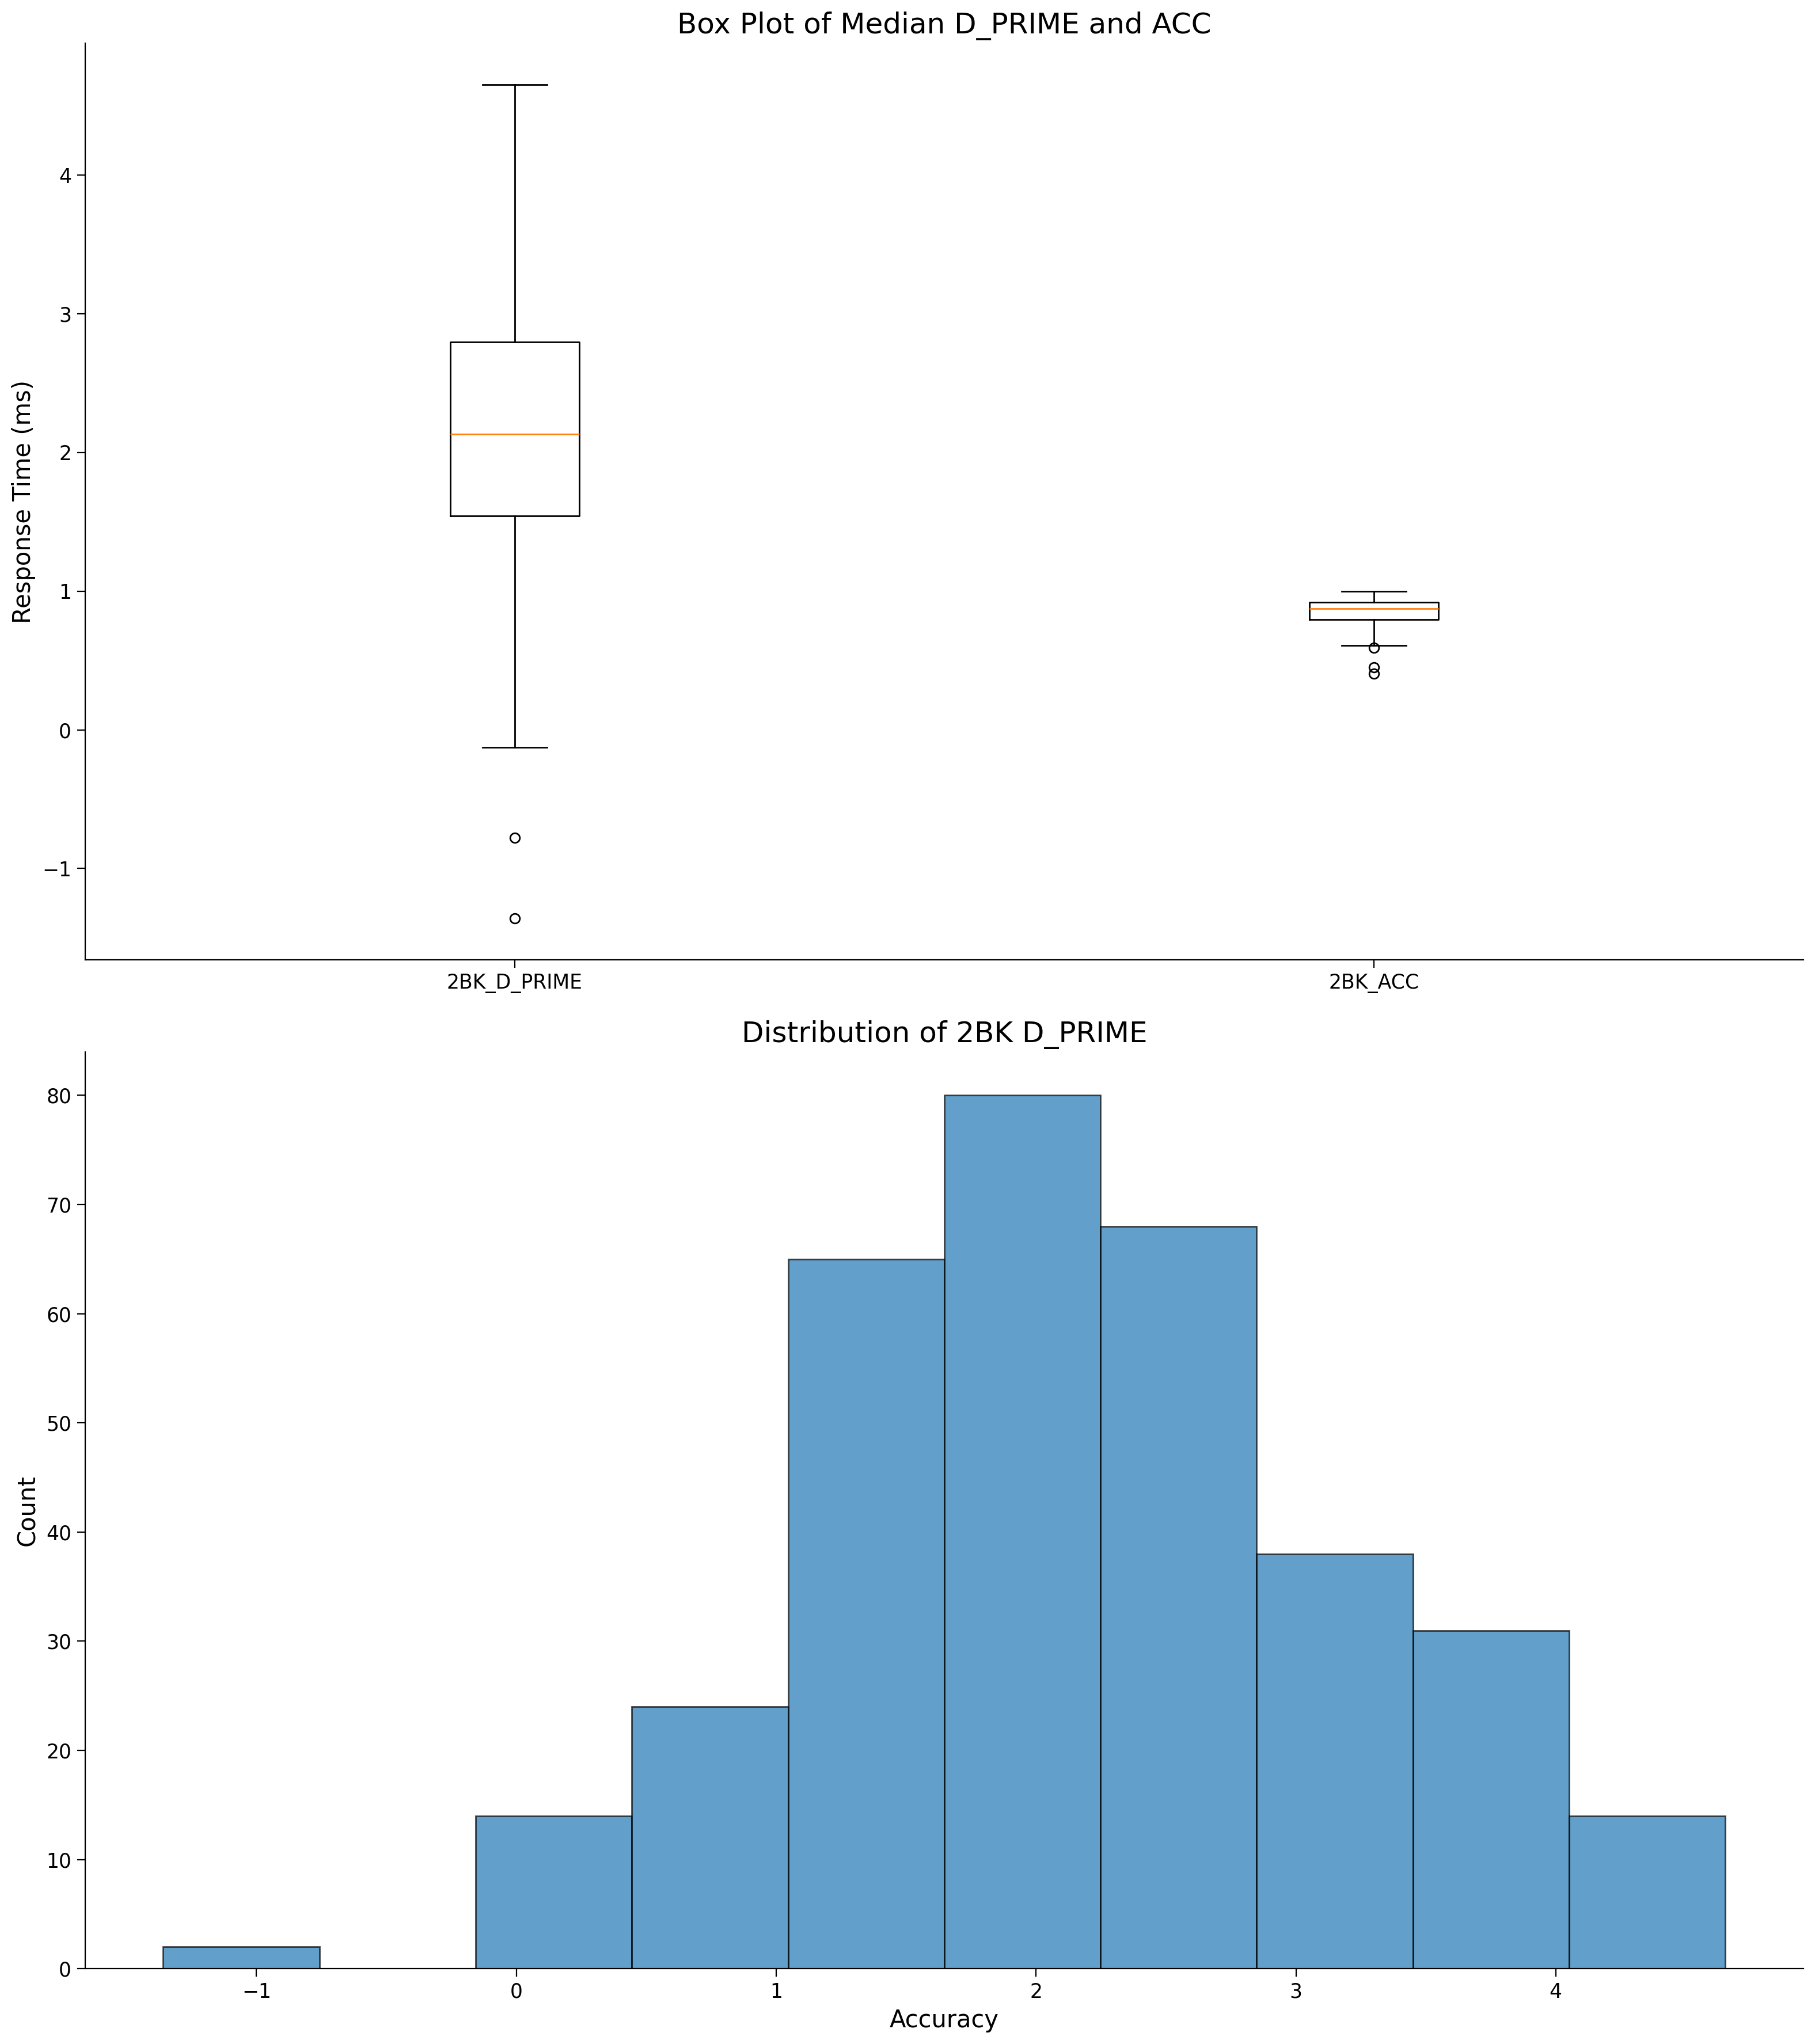

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 18))
axes[0].boxplot([memory_performance_metrics['2BK_D_PRIME'].dropna(), memory_performance_metrics['2BK_ACC'].dropna()], labels=['2BK_D_PRIME', '2BK_ACC'])
axes[0].set_title('Box Plot of Median D_PRIME and ACC')
axes[0].set_ylabel('Response Time (ms)')

axes[1].hist(memory_performance_metrics['2BK_D_PRIME'].dropna(), bins=10, edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of 2BK D_PRIME')
axes[1].set_xlabel('Accuracy')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()